In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("talk")

In [2]:
dev_lim = 10_000 # used only 10,000 pre and 10,000 post neurons for fast developement
# dev_lim = None

## Data Preparation

In [3]:
# >=5 syn threshold was applied to the following data already
ver = 630

fdir = "data/synapse_coordinates.csv"
# load id as integers and allowing NaN
syn_xyz = pd.read_csv(fdir, dtype={'pre_root_id': pd.Int64Dtype(), 'post_root_id': pd.Int64Dtype(), 
                                   'x': np.int32, 'y': np.int32, 'z': np.int32})

fdir = "data/connections.csv"
syn_table = pd.read_csv(fdir)

In [4]:
# check if # of syn. matches
syn_table.syn_count.sum(), len(syn_xyz)

(32970606, 32970606)

In [5]:
# according to the description: also for compactness, 
# empty pre/post id columns should be inferred by 
# looking up in the table at the last non-empty 
# value respectively.

syn_xyz.fillna(method='ffill', inplace=True)

/var/folders/lq/1wn16kmd2k1g0rjr_hy10kvr0000gn/T/ipykernel_47118/3673498734.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  syn_xyz.fillna(method='ffill', inplace=True)


In [6]:
# convert id to long int (faster than pd.Int64)
syn_xyz.pre_root_id = syn_xyz.pre_root_id.astype(np.int64)
syn_xyz.post_root_id = syn_xyz.post_root_id.astype(np.int64)

In [7]:
# x, y, z in nanometers
syn_xyz.head()

,pre_root_id,post_root_id,x,y,z
0,720575940630786105,720575940610739662,366592,246144,74360
1,720575940630786105,720575940610739662,391136,239964,68720
2,720575940630786105,720575940610739662,363584,261920,93480
3,720575940630786105,720575940610739662,363328,261792,93800
4,720575940630786105,720575940610739662,364512,253304,86000


In [8]:
# check number of neurons
len(np.unique(syn_table[['pre_root_id', 'post_root_id']])), len(np.unique(syn_xyz[['pre_root_id', 'post_root_id']]))

(124891, 124891)

## Build Proximity Model

### Step 1. Compute Average Pre-Synaptic and Post-Synaptic Centroids

In [9]:
pre_centers = syn_xyz.groupby('pre_root_id')[['x', 'y', 'z']].mean()
post_centers = syn_xyz.groupby('post_root_id')[['x', 'y', 'z']].mean()

In [10]:
pre_centers.head()

,x,y,z
pre_root_id,,,
720575940596125868,709287.591837,272113.428571,222691.836735
720575940597856265,772089.316708,332566.503741,182286.882793
720575940597944841,728771.803922,315768.274510,163000.000000
720575940598267657,707515.449541,291752.000000,153511.559633
720575940599333574,712178.842444,301777.594855,131212.025723


In [11]:
post_centers.head()

,x,y,z
post_root_id,,,
720575940596125868,704764.444444,264666.060606,207077.171717
720575940597856265,794223.508380,343040.938547,196743.463687
720575940597944841,767888.712871,334382.693069,167095.841584
720575940598267657,702148.700000,288318.640000,164959.600000
720575940599333574,723453.179856,307823.165468,105890.359712


In [12]:
del syn_xyz

### Step 2. Compute Pairwise Distance between Pre-Synaptic and Post-Synaptic Centroids

In [13]:
from scipy.spatial import distance_matrix

In [14]:
pdist = pd.DataFrame(
        distance_matrix(pre_centers.loc[pre_centers.index[:dev_lim]], 
                                        post_centers.loc[post_centers.index[:dev_lim]],
                        threshold= 124891 * 124891 * 3 # ~ 180GB data
                        ),
        columns=post_centers.index[:dev_lim],
        index=pre_centers.index[:dev_lim]
        )

In [15]:
pdist

post_root_id,720575940596125868,720575940597856265,720575940597944841,720575940598267657,720575940599333574,720575940599457990,720575940599459782,720575940599704006,720575940599729862,720575940599733446,...,720575940611351514,720575940611352014,720575940611352234,720575940611352418,720575940611352469,720575940611352538,720575940611353457,720575940611353554,720575940611353806,720575940611353954
pre_root_id,,,,,,,,,,,,,,,,,,,,,
720575940596125868,17881.272761,113657.994238,101992.486804,60386.950681,122957.042205,84137.828029,54559.170873,70025.856561,64435.515084,62175.718777,...,112517.688448,224658.228650,77655.385648,488583.603815,120119.806715,304682.984403,256192.222411,435562.475153,411522.762545,456896.771419
720575940597856265,98780.904168,28436.401963,15865.413618,84556.478404,93883.626558,66490.881945,89906.373659,70043.957014,72293.282892,73759.263225,...,182577.156516,267368.195902,148632.060698,557337.340023,129319.403238,368494.769706,302230.121662,512768.086477,486708.449949,515417.956110
720575940597944841,71628.113486,78526.079501,43513.274554,38289.843683,57904.434489,22141.172762,53407.767683,28368.088699,30838.350175,33904.777571,...,144902.162267,217184.453952,119948.628419,513568.606361,105336.317907,320186.373073,252155.258229,468952.296945,442337.060954,476004.456148
720575940598267657,60087.360899,109625.910318,75145.456501,13101.434646,52726.390821,35695.876853,50226.234416,36746.014865,35555.259020,38060.983739,...,114910.306491,189217.417907,96882.279240,491007.664810,87780.512731,287283.902800,221547.914775,444090.378411,417469.341939,459303.157809
720575940599333574,84780.656100,112820.034138,73853.438196,37691.457823,28369.814552,37460.811198,68900.760963,48086.875832,49938.138145,53369.586276,...,129994.516457,188141.980373,116121.742145,499528.500665,88997.718688,291613.181756,220264.509310,455116.791694,427823.371644,467105.625131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720575940611287928,398273.563717,487830.515461,464249.365964,398955.886739,433115.435818,408183.451589,378173.157289,398813.766013,396375.815190,394323.124948,...,380440.402742,277140.768618,407126.487930,105079.634110,460508.533311,297682.585860,295222.091901,117191.249285,102008.853011,69910.935352
720575940611287978,262221.266455,358388.985774,323128.105454,248274.248551,261140.699825,267499.477560,253846.147590,264636.446972,262548.277308,262412.271071,...,204083.692660,71640.234001,245852.952024,293602.724396,269972.814397,87798.848244,51080.693070,249982.468496,222399.423657,305947.403705
720575940611288689,143137.478149,74583.774701,73661.663387,129572.582466,114630.277679,123412.630934,152348.994037,131248.502575,133017.289923,135335.701758,...,201752.812420,304154.908039,167267.739869,613705.598776,116549.623125,391661.854965,329775.643121,565025.579192,538985.424632,579397.482035


In [16]:
pdist.reset_index(inplace=True)
pdist.reset_index(drop = True, inplace=True)
pdist = pdist.melt(id_vars=['pre_root_id'], var_name='post_root_id', value_name='dist')

In [17]:
# remove autapses since they are not in our dataset
mask_autapses = (pdist.pre_root_id == pdist.post_root_id)
pdist = pdist[~mask_autapses]

In [18]:
pdist

,pre_root_id,post_root_id,dist
1,720575940597856265,720575940596125868,98780.904168
2,720575940597944841,720575940596125868,71628.113486
3,720575940598267657,720575940596125868,60087.360899
4,720575940599333574,720575940596125868,84780.656100
5,720575940599457990,720575940596125868,57368.897847
...,...,...,...
99999995,720575940611287928,720575940611353954,69910.935352
99999996,720575940611287978,720575940611353954,305947.403705
99999997,720575940611288689,720575940611353954,579397.482035
99999998,720575940611288690,720575940611353954,303410.461514


### Step 3. Compute Pairwise Connections

In [19]:
dev_mask = syn_table.pre_root_id.isin(pre_centers.index[:dev_lim]) & syn_table.post_root_id.isin(post_centers.index[:dev_lim])
pconn = syn_table[dev_mask].groupby(['pre_root_id', 'post_root_id']).sum()[['syn_count']]
pconn['connected'] = 1

In [20]:
del syn_table

In [21]:
pconn

syn_count  connected
pre_root_id        post_root_id                            
720575940596125868 720575940608552405          5          1
                   720575940611348834          7          1
720575940597856265 720575940605842278         11          1
                   720575940609624003          8          1
                   720575940610239790         12          1
...                                          ...        ...
720575940611285454 720575940610964946          6          1
720575940611285858 720575940608810435          7          1
720575940611287978 720575940606198473          5          1
720575940611290005 720575940604003104          5          1
                   720575940607245186          7          1

[17063 rows x 2 columns]

### Step 4. Compute Connection Probability as a Function of Distance

In [22]:
dist_vs_syn = pdist.merge(pconn, how='left', on=['pre_root_id', 'post_root_id']).fillna(0)

In [23]:
n_bins = 50
dist_vs_syn['dist_bins'] = pd.qcut(dist_vs_syn.dist, q=np.linspace(0,1,n_bins))

In [24]:
error = lambda x: np.std(x) / np.sqrt(len(dist_vs_syn) // n_bins)
dist_vs_syn_fn =  dist_vs_syn.groupby('dist_bins').agg({'syn_count': [('mean', np.mean), ('error', error)], 
                                        'connected': [('mean', np.mean), ('error', error)]})
# dist_vs_syn_fn                                        

/var/folders/lq/1wn16kmd2k1g0rjr_hy10kvr0000gn/T/ipykernel_47118/3691504039.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dist_vs_syn_fn =  dist_vs_syn.groupby('dist_bins').agg({'syn_count': [('mean', np.mean), ('error', error)],
/var/folders/lq/1wn16kmd2k1g0rjr_hy10kvr0000gn/T/ipykernel_47118/3691504039.py:2: FutureWarning: The provided callable <function mean at 0x1075f53a0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  dist_vs_syn_fn =  dist_vs_syn.groupby('dist_bins').agg({'syn_count': [('mean', np.mean), ('error', error)],


In [25]:
# dist_vs_syn_fn = pd.read_pickle('saved/dist_vs_syn_fn_n=10000.pkl')

In [26]:
dist_vs_syn_fn

syn_count               connected              
                              mean     error          mean         error
dist_bins                                                               
(200.893, 43432.185]      0.076315  0.001399  5.483132e-03  5.221873e-05
(43432.185, 56880.468]    0.011611  0.000412  9.516711e-04  2.180432e-05
(56880.468, 67049.226]    0.005807  0.000253  5.253303e-04  1.620347e-05
(67049.226, 75732.119]    0.003480  0.000186  3.239210e-04  1.272492e-05
(75732.119, 83590.052]    0.002724  0.000212  2.278718e-04  1.067337e-05
(83590.052, 90940.148]    0.001715  0.000165  1.470141e-04  8.573406e-06
(90940.148, 97990.653]    0.001360  0.000180  1.171212e-04  7.652409e-06
(97990.653, 104887.76]    0.001063  0.000111  9.310891e-05  6.823092e-06
(104887.76, 111720.359]   0.000862  0.000103  6.909661e-05  5.877860e-06
(111720.359, 118573.935]  0.000632  0.000082  5.831558e-05  5.399897e-06
(118573.935, 125534.082]  0.000611  0.000086  5.488525e-05  5.238679e-06
(125534.082, 132642.273]  0.000529  0.000094  4.067389e-05  4.509775e-06
(132642.273, 139917.941]  0.000667  0.000112  4.557434e-05  4.773711e-06
(139917.941, 147381.363]  0.000387  0.000063  3.283314e-05  4.051865e-06
(147381.363, 155070.385]  0.000279  0.000042  2.940281e-05  3.834369e-06
(155070.385, 162993.924]  0.000333  0.000058  3.136300e-05  3.960115e-06
(162993.924, 171172.6]    0.000293  0.000059  2.499239e-05  3.535121e-06
(171172.6, 179550.353]    0.000147  0.000027  1.764169e-05  2.970107e-06
(179550.353, 188154.267]  0.000195  0.000040  1.911183e-05  3.091383e-06
(188154.267, 196887.26]   0.000094  0.000023  1.127108e-05  2.374030e-06
(196887.26, 205662.506]   0.000086  0.000021  1.029098e-05  2.268465e-06
(205662.506, 214421.692]  0.000099  0.000029  8.820844e-06  2.100192e-06
(214421.692, 223153.277]  0.000055  0.000020  4.900469e-06  1.565394e-06
(223153.277, 231947.037]  0.000027  0.000014  2.940281e-06  1.212550e-06
(231947.037, 240881.382]  0.000026  0.000012  2.940280e-06  1.212550e-06
(240881.382, 250021.637]  0.000057  0.000017  6.860657e-06  1.852197e-06
(250021.637, 259435.754]  0.000053  0.000020  5.880563e-06  1.714802e-06
(259435.754, 269159.895]  0.000023  0.000010  2.940281e-06  1.212550e-06
(269159.895, 279219.085]  0.000000  0.000000  0.000000e+00  0.000000e+00
(279219.085, 289492.614]  0.000010  0.000006  1.470141e-06  8.574030e-07
(289492.614, 299936.847]  0.000023  0.000009  3.430328e-06  1.309703e-06
(299936.847, 310672.687]  0.000002  0.000002  4.900469e-07  4.950221e-07
(310672.687, 321827.363]  0.000000  0.000000  0.000000e+00  0.000000e+00
(321827.363, 333394.281]  0.000012  0.000007  1.470141e-06  8.574030e-07
(333394.281, 345374.738]  0.000007  0.000005  9.800938e-07  7.000668e-07
(345374.738, 357713.074]  0.000004  0.000004  4.900469e-07  4.950221e-07
(357713.074, 370303.274]  0.000002  0.000002  4.900467e-07  4.950220e-07
(370303.274, 383073.173]  0.000012  0.000006  1.960188e-06  9.900434e-07
(383073.173, 395916.187]  0.000000  0.000000  0.000000e+00  0.000000e+00
(395916.187, 408812.828]  0.000003  0.000003  4.900469e-07  4.950221e-07
(408812.828, 421799.976]  0.000000  0.000000  0.000000e+00  0.000000e+00
(421799.976, 435029.492]  0.000003  0.000003  4.900469e-07  4.950221e-07
(435029.492, 448553.338]  0.000000  0.000000  0.000000e+00  0.000000e+00
(448553.338, 462479.273]  0.000000  0.000000  0.000000e+00  0.000000e+00
(462479.273, 477325.579]  0.000000  0.000000  0.000000e+00  0.000000e+00
(477325.579, 494024.464]  0.000000  0.000000  0.000000e+00  0.000000e+00
(494024.464, 514060.602]  0.000000  0.000000  0.000000e+00  0.000000e+00
(514060.602, 541751.553]  0.000000  0.000000  0.000000e+00  0.000000e+00
(541751.553, 771157.53]   0.000000  0.000000  0.000000e+00  0.000000e+00

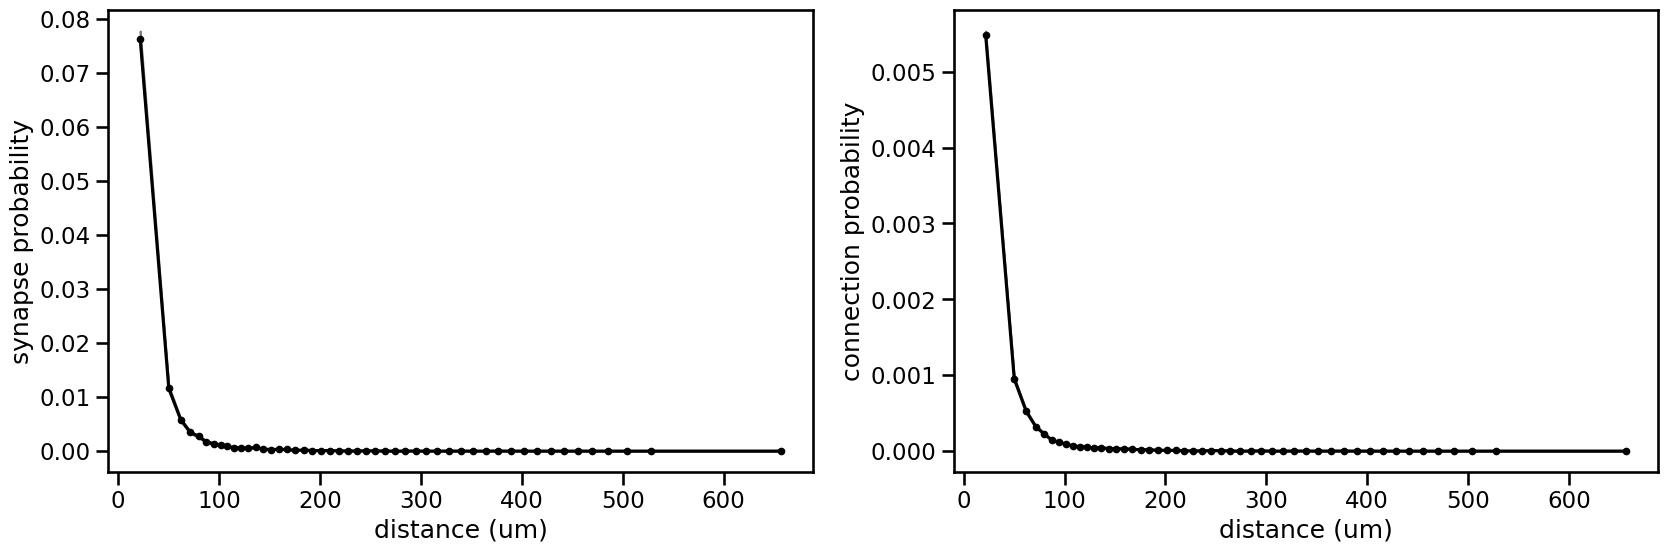

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
for ax, syn_type, pt_name in zip(axs, ['syn_count', 'connected'], ['synapse probability', 'connection probability']):
    dist_mids = np.array([itv.mid for itv in dist_vs_syn_fn.index]) / 1_000
    ax.plot(dist_mids, dist_vs_syn_fn[syn_type]['mean'], color='k', marker ='.')
    ax.fill_between(dist_mids, 
                        dist_vs_syn_fn[syn_type]['mean'] - dist_vs_syn_fn[syn_type]['error'],
                        dist_vs_syn_fn[syn_type]['mean'] + dist_vs_syn_fn[syn_type]['error'], 
                        color='gray')
    ax.set_xlabel('distance (um)')
    ax.set_ylabel(pt_name)

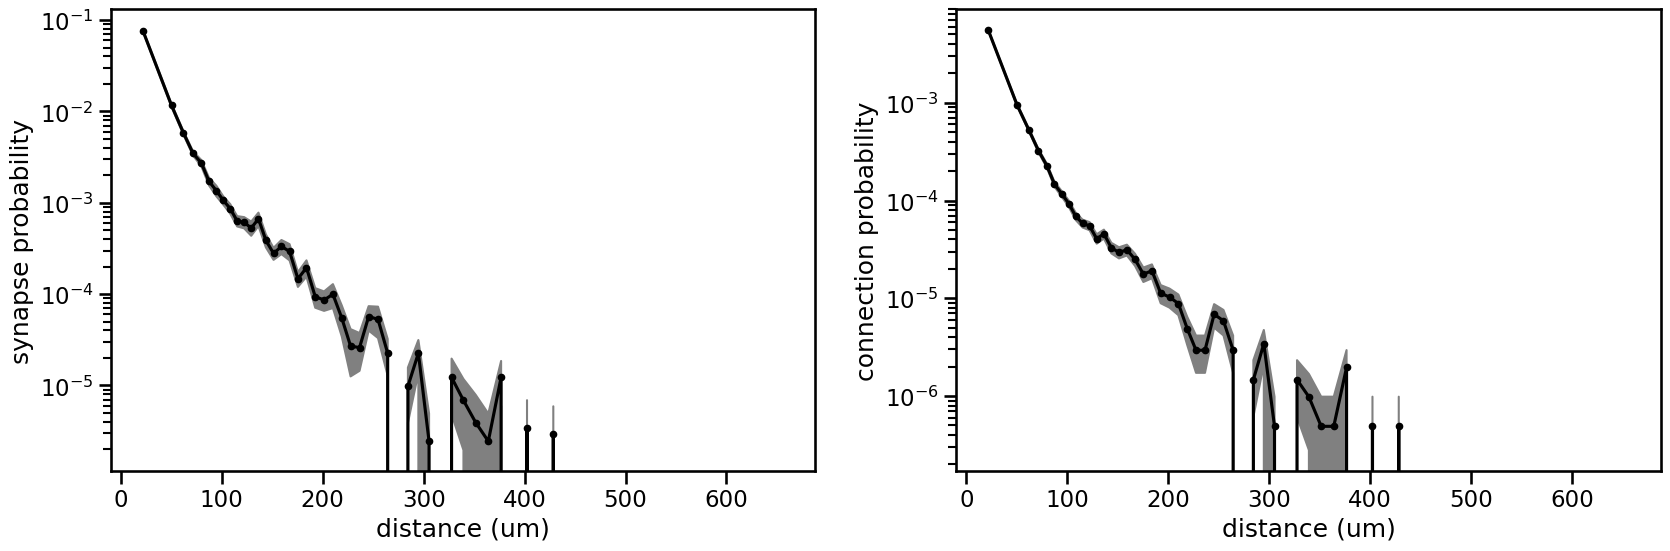

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
for ax, syn_type, pt_name in zip(axs, ['syn_count', 'connected'], ['synapse probability', 'connection probability']):
    dist_mids = np.array([itv.mid for itv in dist_vs_syn_fn.index]) / 1_000
    ax.plot(dist_mids, dist_vs_syn_fn[syn_type]['mean'], color='k', marker ='.')
    ax.fill_between(dist_mids, 
                        dist_vs_syn_fn[syn_type]['mean'] - dist_vs_syn_fn[syn_type]['error'],
                        dist_vs_syn_fn[syn_type]['mean'] + dist_vs_syn_fn[syn_type]['error'], 
                        color='gray')
    ax.set_xlabel('distance (um)')
    ax.set_yscale('log')
    ax.set_ylabel(pt_name)
# plt.savefig('figures/stats-630/dist-vs-conn.pdf', bbox_inches='tight')

In [41]:
dist_vs_syn['dist_bins'] = pd.cut(dist_vs_syn.dist, [0, 50*1e3, 700*1e3])

In [42]:
error = lambda x: np.std(x) / np.sqrt(len(dist_vs_syn) // n_bins)
dist_vs_syn_fn =  dist_vs_syn.groupby('dist_bins').agg({'syn_count': [('mean', np.mean), ('error', error)], 
                                        'connected': [('mean', np.mean), ('error', error)]})
# dist_vs_syn_fn                                        

/var/folders/lq/1wn16kmd2k1g0rjr_hy10kvr0000gn/T/ipykernel_47118/3691504039.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dist_vs_syn_fn =  dist_vs_syn.groupby('dist_bins').agg({'syn_count': [('mean', np.mean), ('error', error)],
/var/folders/lq/1wn16kmd2k1g0rjr_hy10kvr0000gn/T/ipykernel_47118/3691504039.py:2: FutureWarning: The provided callable <function mean at 0x1075f53a0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  dist_vs_syn_fn =  dist_vs_syn.groupby('dist_bins').agg({'syn_count': [('mean', np.mean), ('error', error)],


In [43]:
# dist_vs_syn_fn = pd.read_pickle('saved/dist_vs_syn_fn_n=10000.pkl')

In [44]:
dist_vs_syn_fn

syn_count           connected          
                         mean     error      mean     error
dist_bins                                                  
(0.0, 50000.0]       0.057453  0.001196  0.004166  0.000046
(50000.0, 700000.0]  0.000564  0.000085  0.000050  0.000005

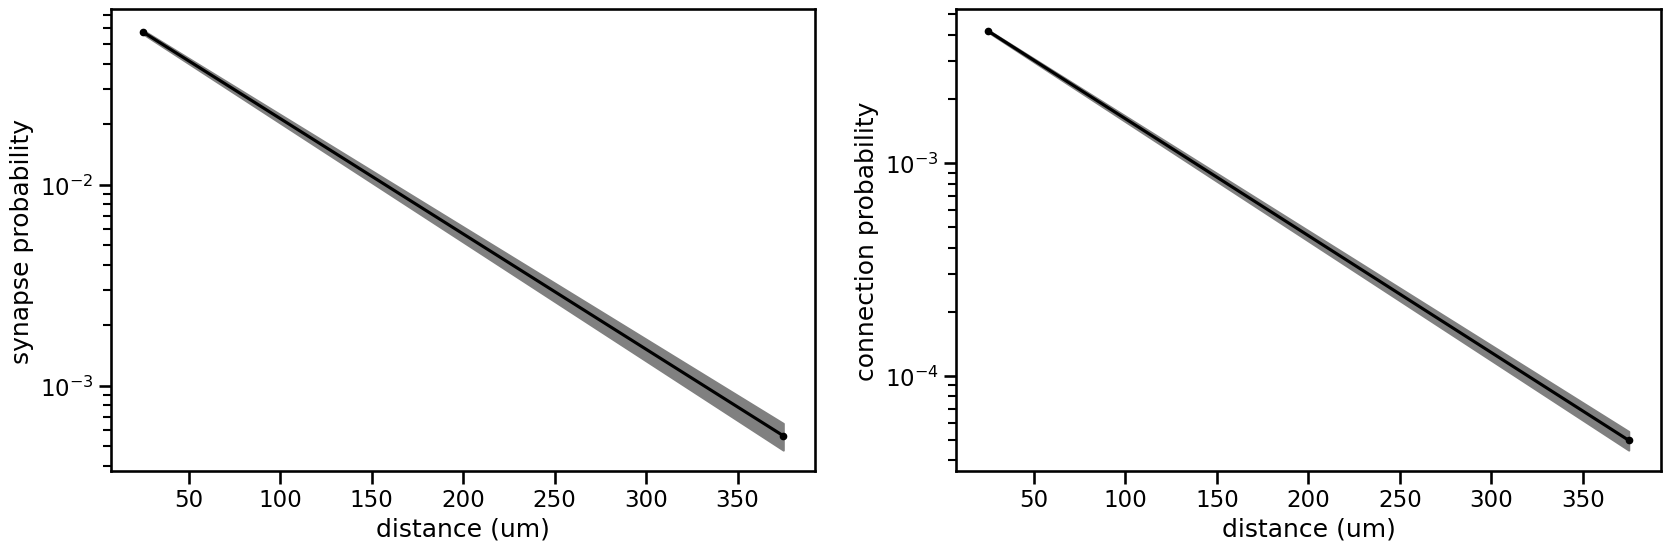

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
for ax, syn_type, pt_name in zip(axs, ['syn_count', 'connected'], ['synapse probability', 'connection probability']):
    dist_mids = np.linspace(0, 7800000, 79) / 1_000
    ax.plot(dist_mids, dist_vs_syn_fn[syn_type]['mean'], color='k')
    ax.fill_between(dist_mids, 
                        dist_vs_syn_fn[syn_type]['mean'] - dist_vs_syn_fn[syn_type]['error'],
                        dist_vs_syn_fn[syn_type]['mean'] + dist_vs_syn_fn[syn_type]['error'], 
                        color='gray')
    ax.set_xlabel('distance (um)')
    ax.set_yscale('log')
    ax.set_ylabel(pt_name)
# plt.savefig('figures/stats-630/dist-vs-conn.pdf', bbox_inches='tight')

In [50]:
dist_vs_syn_fn[syn_type]['mean'].values

array([4.16562634e-03, 4.96347436e-05])

array([      0.,  100000.,  200000.,  300000.,  400000.,  500000.,
        600000.,  700000.,  800000.,  900000., 1000000., 1100000.,
       1200000., 1300000., 1400000., 1500000., 1600000., 1700000.,
       1800000., 1900000., 2000000., 2100000., 2200000., 2300000.,
       2400000., 2500000., 2600000., 2700000., 2800000., 2900000.,
       3000000., 3100000., 3200000., 3300000., 3400000., 3500000.,
       3600000., 3700000., 3800000., 3900000., 4000000., 4100000.,
       4200000., 4300000., 4400000., 4500000., 4600000., 4700000.,
       4800000., 4900000., 5000000., 5100000., 5200000., 5300000.,
       5400000., 5500000., 5600000., 5700000., 5800000., 5900000.,
       6000000., 6100000., 6200000., 6300000., 6400000., 6500000.,
       6600000., 6700000., 6800000., 6900000., 7000000., 7100000.,
       7200000., 7300000., 7400000., 7500000., 7600000., 7700000.,
       7800000.])